In [1]:
from casadi import Opti,log,exp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Randomly initialize parameters. Individuals and facilities are distributed uniformly randomly around a unit square. Individual types $\theta_i \sim \text{Bernoulli}(\frac{1}{2})$. That is,
$$
\theta_i=\begin{cases} 
0 : \text{ w.p. } \frac{1}{2}\\
1 : \text{ w.p. } \frac{1}{2}.
\end{cases}
$$

Distances between individuals and facilities are stored in matrix `dist`.

In [2]:
sizeRegion = 1
nIndiv = 18
nFac = 5
nSelectedFac = 2
fac = np.random.uniform(0,sizeRegion,(nFac, 2))
indiv = np.random.uniform(0,sizeRegion,(nIndiv, 2))
theta = np.array([np.random.choice([0,1]) for i in range(nIndiv)])
dist = np.array([[ (indiv[i,0] - fac[j,0])**2 + (indiv[i,1] - fac[j,1])**2 for j in range(0,nFac)] for i in range(0,nIndiv)]) # nIndiv X nFac

The stochastic model is that

$$
P(\text{success of individual } i) = f(\theta_i,r_i)= \frac{1}{1 + e^{-(\beta_0 + \beta_\theta \theta_i + \beta_r r_i)}}.
$$
where $r_i$ represents the distance of individual $i$ from the nearest selected facility, and $\beta_r <0$ indicates that increasing distance causes decreased probability of success. Higher type $\theta_i$ corresponds to a higher probability of success, so $\beta_\theta >0$.

In this code, $\beta_0=0$, so a type-$0$ individual ($\theta_i = 0$) with no distance to the nearest facility ($r_i=0$) has precisely a $\frac{1}{2}$ probability of success. Increasing $\beta_0$ increases the probability of success for all individuals.

We let $\beta = (\beta_0, \beta_\theta, \beta_r)$.

In [3]:
beta = [0,4,-1] #[beta0, beta_theta >0, beta_r <0]

We implement the following optimization model in the `CasADI` Python interface to COIN-OR's `Bonmin` MINLP solver:

$$
\begin{array}{llll}
            \max & \displaystyle\sum_{i=1}^N u_i & &\\
            \text{s.t.} & u_i &= f(\theta_i,r_i),&i = 1,\ldots,N\\
                        & r_i &\ge d_{ij} x_{ij},&i=1,\ldots,N,j=1,\ldots,M\\
                        & \displaystyle\sum_{j=1}^M x_{ij} &=1,&i=1,\ldots,N\\
                        & x_{ij} &\le y_j, &i=1,\ldots,N,j=1,\ldots,M\\
                        &\displaystyle\sum_{j=1}^M y_j &\le m&\\
                        & x_{ij},y_j &\in \{0,1\},&i=1,\ldots,N,j=1,\ldots,M. 
\end{array}
$$

In [4]:
opti = Opti()
x = [[opti.variable() for j in range(nFac)] for i in range(nIndiv)] # nIndiv X nFac
y = [opti.variable() for j in range(nFac)]
r = [opti.variable() for i in range(nIndiv)]
u = [opti.variable() for i in range(nIndiv)]
discrete = []
discrete += [True  for j in range(nFac) for i in range(nIndiv)] #x variables
discrete += [True  for j in range(nFac)] #y variables
discrete += [False for i in range(nIndiv)] #r variables
discrete += [False for i in range(nIndiv)] #u variables
opti.minimize(-sum(u))#maximize sum u
opti.subject_to([u[i] == -log(1+exp(-beta[0] - beta[1]*theta[i] - beta[2]*r[i])) for i in range(nIndiv)]) #log prob(success)
# opti.subject_to([u[i] == 1/(1+exp(-beta[0] - beta[1]*theta[i] - beta[2]*r[i])) for i in range(nIndiv)]) #prob(success)
opti.subject_to([r[i] >= dist[i,j]*x[i][j] for i in range(nIndiv) for j in range(nFac)])
opti.subject_to([ sum(x[i]) == 1 for i in range(nIndiv) ])
opti.subject_to([ x[i][j] <= y[j] for i in range(nIndiv) for j in range(nFac)])
opti.subject_to(sum(y) <= nSelectedFac)
opti.subject_to([ opti.bounded(0,y[j],1) for j in range(nFac)])
opti.subject_to([ opti.bounded(0,x[i][j],1) for i in range(nIndiv) for j in range(nFac)])
p_options = {"discrete":discrete,"expand":True}
s_options = {"max_iter": 100}
opti.solver('bonmin',p_options,s_options)
sol = opti.solve()
xvals = np.array([[int(sol.value(x[i][j])) for j in range(nFac)] for i in range(nIndiv)])
yvals = np.array([int(sol.value(y[j])) for j in range(nFac)])
rvals = np.array([sol.value(r[i]) for i in range(nIndiv)])
uvals = np.array([sol.value(u[i]) for i in range(nIndiv)])
obj_vals = np.array([-log(1+exp(-beta[0] - beta[1]*theta[i] - beta[2]*rvals[i])) for i in range(nIndiv)])
prob_success = np.array([1/(1+exp(-beta[0] - beta[1]*theta[i] - beta[2]*rvals[i])) for i in range(nIndiv)])
fstar = sol.value(opti.f)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 8.6327945       18 0.039548
NLP0014I             2         OPT 8.6588204       16 0.02145
NLP0014I             3         OPT 8.68763       22 0.0296
NLP0014I             4         OPT 8.646257       18 0.029793
NLP0014I             5         OPT 8.697971       23 0.032284
NLP0014I             6         OPT 8.6363874       18 0.025181
NLP0014I             7         OPT 8.6873847       26 0.038806
NLP0014I             8         OPT 8.6362953       18 0.030387
NLP0014I       

NLP0014I           118         OPT 8.632896       14 0.017989
NLP0014I           119         OPT 8.8000463       19 0.028688
NLP0014I           120         OPT 8.640813       14 0.020591
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I           121         OPT 8.7635007       23 0.030817
NLP0014I           122         OPT 8.6329093       14 0.018238
NLP0014I           123         OPT 8.736198       21 0.027215
NLP0014I           124         OPT 8.6332676       15 0.019933
NLP0014I           125         OPT 8.697295       21 0.027602
NLP0014I           126         OPT 8.642147       15 0.020451
NLP0014I           127         OPT 8.825296       21 0.02742
NLP0014I           128         OPT 8.6364982       14 0.018849
NLP0014I           129         OPT 9.0283474       21 0.030543
NLP0014I           130         OPT 8.634186       15 0.021495
NLP0014I           131         OPT 8.6914441       20 0.026371
NLP0014I           132    

NLP0014I           244         OPT 8.7097661       18 0.029978
NLP0014I           245         OPT 8.9174023       19 0.029082
NLP0014I           246         OPT 8.7159985       18 0.025818
NLP0014I           247         OPT 8.9220683       19 0.025604
NLP0014I           248         OPT 8.7485291       18 0.024004
NLP0014I           249         OPT 8.9137751       20 0.02776
NLP0014I           250         OPT 8.7578475       18 0.026007
NLP0014I           251         OPT 8.9425141       23 0.032427
NLP0014I           252         OPT 8.7615087       16 0.019809
NLP0014I           253         OPT 8.9062453       19 0.025318
NLP0014I           254         OPT 8.8034045       18 0.023959
NLP0014I           255         OPT 8.9647253       21 0.027752
NLP0014I           256         OPT 8.8120371       19 0.032058
NLP0014I           257         OPT 9.3518607       19 0.028847
NLP0014I           258         OPT 8.846739       18 0.02607
NLP0014I           259         OPT 8.8937849       20 0.03

## Plot the solution:

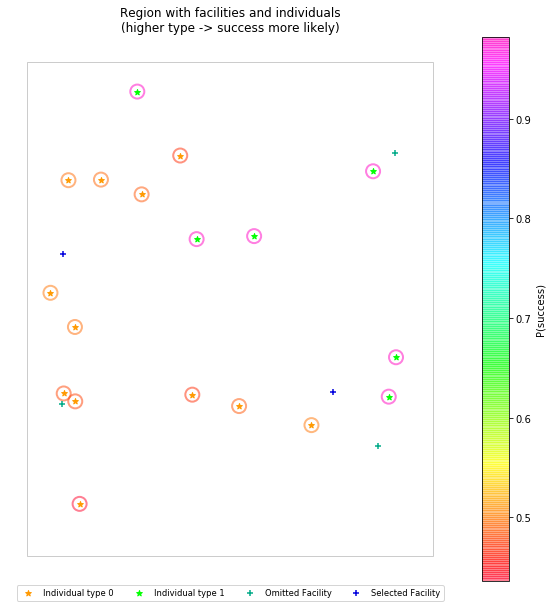

In [8]:
def plot_region():
	number_desired_colors = 6
	cmap = plt.cm.get_cmap('nipy_spectral',number_desired_colors)
	colors = [cmap(i) for i in range(number_desired_colors)]
	fig, ax = plt.subplots(figsize=(10,10))
	plt.axis('off')
	plt.title(f"Region with facilities and individuals\n(higher type -> success more likely)")

	## Plot Region
	# labelRegion="Region"
	region = patches.Rectangle((0,0),sizeRegion,sizeRegion,linewidth=1,edgecolor=colors.pop(),facecolor="none")
	ax.add_patch(region)

	# plt.plot([*r.getExteriorCoords()],color=colors.pop(),label=labelRegion)


	## Plot Objectives
	def plotObjectives():
		obj_scatter = plt.scatter(indiv[:,0],indiv[:,1],marker="o",s=14**2,lw=2,alpha=0.5,c=prob_success,cmap="gist_rainbow",label="no_legend")
		obj_scatter.set_facecolor('none')
		cbar = plt.colorbar(obj_scatter)
		cbar.ax.set_ylabel('P(success)')
	plotObjectives()


	## Plot Individuals
	labelIndividuals = "Individual"
	def plotIndividuals():
		# plt.scatter(*pop.getIndividualCoordinates(),marker="*",c="blue",label="Individual")
		color_weight_map = {ttheta : colors.pop() for ttheta in set(theta)}
		individual_colors = [color_weight_map[ttheta] for ttheta in theta]
		individual_labels = [f"{labelIndividuals} type {ttheta}" for coords,ttheta in zip(indiv,theta)]
		for i,coords in enumerate(indiv):
			plt.scatter(*coords,marker = "*",c=[individual_colors[i]],label=individual_labels[i])
	plotIndividuals()




	## Plot Facilities
	labelFacility = "Facility"
	def plotFacilities():
		facility_color_map = {yval : colors.pop() for yval in set(yvals)}
		facility_colors = [facility_color_map[yval] for yval in yvals]
		facility_states = ["Omitted", "Selected"]
		facility_labels = [f"{facility_states[yval]} {labelFacility}" for yval in yvals]
		for i, coords in enumerate(fac):
			plt.scatter(*coords,marker = "+",c=[facility_colors[i]],label=facility_labels[i])
			# plt.scatter(*r.getFacilityLocations(),marker="+",c=[colors.pop()],label=labelFacility)
	plotFacilities()
	## Create Legend

	legend_dict = {legendTitle : artist for artist in ax.collections.copy() + ax.lines.copy() if "no_legend" not in (legendTitle:=artist.properties().get('label'))}
	plt.legend(legend_dict.values(),legend_dict.keys(),loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(legend_dict),fontsize='small') #,loc="upper right"

	# plt.tight_layout()
	plt.show(block=False)
	return fig,ax

fig,ax = plot_region()